In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer

import re

In [ ]:
 %pip install transformers[torch] 

In [27]:
from transformers import pipeline
 
# Downloading the sentiment analysis model
SentimentClassifier = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
cd './drive/MyDrive/dawn_chorus'

/content/drive/MyDrive/dawn_chorus


In [11]:
df = pd.read_csv('pa_reps2022-07-19.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (18,63,64,65,66,67,68) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [12]:
pd.set_option('display.max_columns', None)

In [13]:
df.head(2)

,created_at,district,Representative,party,screen_name,text,source,display_text_width,reply_to_status_id,reply_to_user_id,reply_to_screen_name,is_quote,is_retweet,favorite_count,retweet_count,quote_count,reply_count,hashtags,symbols,urls_url,urls_t.co,urls_expanded_url,media_url,media_t.co,media_expanded_url,media_type,ext_media_url,ext_media_t.co,ext_media_expanded_url,ext_media_type,mentions_user_id,mentions_screen_name,lang,quoted_status_id,quoted_text,quoted_created_at,quoted_source,quoted_favorite_count,quoted_retweet_count,quoted_user_id,quoted_screen_name,quoted_name,quoted_followers_count,quoted_friends_count,quoted_statuses_count,quoted_location,quoted_description,quoted_verified,retweet_status_id,retweet_text,retweet_created_at,retweet_source,retweet_favorite_count,retweet_retweet_count,retweet_user_id,retweet_screen_name,retweet_name,retweet_followers_count,retweet_friends_count,retweet_statuses_count,retweet_location,retweet_description,retweet_verified,place_url,place_name,place_full_name,place_type,country,country_code,coords_coords,bbox_coords,status_url,name.x,location,description,url,protected,followers_count,friends_count,listed_count,statuses_count,favourites_count,account_created_at,verified
0,2022-07-18T23:57:58Z,PA-01,Brian Fitzpatrick,Republican,@repbrianfitz,"Now more than ever, it is critical that we pro...",Twitter for iPhone,185,NaN,NaN,NaN,False,False,4,1,NaN,NaN,NaN,NaN,riponadvance.com/stories/fitzpa…,https://t.co/omVag47bcj,https://riponadvance.com/stories/fitzpatricks-...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,|,|||||||,https://twitter.com/RepBrianFitz/status/154918...,Rep. Brian Fitzpatrick 🇺🇸,"Bucks County, PA",A fiercely independent voice for my hometown o...,https://t.co/fDbVS71DZP,False,21431,355,680,3888,480,2017-01-03T15:20:39Z,True
1,2022-07-17T13:38:30Z,PA-01,Brian Fitzpatrick,Republican,@repbrianfitz,Thank you Dr. Umar Farooq and the Association ...,Twitter for iPhone,267,NaN,NaN,NaN,False,False,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,http://pbs.twimg.com/media/FX31LmpXoAEhxJt.jpg,https://t.co/k7ZPU2yTBx,https://twitter.com/RepBrianFitz/status/154866...,photo,http://pbs.twimg.com/media/FX31LmpXoAEhxJt.jpg,https://t.co/k7ZPU2yTBx,https://twitter.com/RepBrianFitz/status/154866...,NaN,826088894865297408,APPNA,en,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,|,|||||||,https://twitter.com/RepBrianFitz/status/154866...,Rep. Brian Fitzpatrick 🇺🇸,"Bucks County, PA",A fiercely independent voice for my hometown o...,https://t.co/fDbVS71DZP,False,21431,355,680,3888,480,2017-01-03T15:20:39Z,True


### Let's narrow down the analysis to a few columns

In [14]:
tweets_df = df[['district', 'Representative', 'party', 'text', 'followers_count']].copy(deep=True)

In [15]:
tweets_df.head()

,district,Representative,party,text,followers_count
0,PA-01,Brian Fitzpatrick,Republican,"Now more than ever, it is critical that we pro...",21431
1,PA-01,Brian Fitzpatrick,Republican,Thank you Dr. Umar Farooq and the Association ...,21431
2,PA-01,Brian Fitzpatrick,Republican,"Today marks the launch of 988, a new lifesavin...",21431
3,PA-01,Brian Fitzpatrick,Republican,I am proud to cosponsor this bipartisan legisl...,21431
4,PA-01,Brian Fitzpatrick,Republican,Joe was a recognized leader in Bristol and Buc...,21431


We have tweets from all 18 congressional leaders in PA

#### Clean the tweets

In [16]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def url_free_text(text):
    '''
    Cleans text from urls
    '''
    text = re.sub(r'http\S+', '', text)
    text = text.replace('amp', ' ')
    return text

# Apply the function above and get tweets free of emoji's
call_emoji_free = lambda x: remove_emojis(x)

# Apply `call_emoji_free` which calls the function to remove all emoji's
tweets_df['text'] = tweets_df['text'].apply(call_emoji_free)

#Create a new column with url free tweets
tweets_df['text'] = tweets_df['text'].apply(url_free_text)

In [17]:
tweets_df.head()

,district,Representative,party,text,followers_count
0,PA-01,Brian Fitzpatrick,Republican,"Now more than ever, it is critical that we pro...",21431
1,PA-01,Brian Fitzpatrick,Republican,Thank you Dr. Umar Farooq and the Association ...,21431
2,PA-01,Brian Fitzpatrick,Republican,"Today marks the launch of 988, a new lifesavin...",21431
3,PA-01,Brian Fitzpatrick,Republican,I am proud to cosponsor this bipartisan legisl...,21431
4,PA-01,Brian Fitzpatrick,Republican,Joe was a recognized leader in Bristol and Buc...,21431


### Sentiment Analysis

In [28]:
# Calling the sentiment analysis function for 3 sentences
SentimentClassifier(["I hope we get all these concepts! Its killing the neurons of our brain",
                     "We had a nice experience in this trip",
                     "Houston we have a problem"
                      ])

[{'label': 'NEGATIVE', 'score': 0.9997034668922424},
 {'label': 'POSITIVE', 'score': 0.9998235106468201},
 {'label': 'NEGATIVE', 'score': 0.9944382905960083}]

In [29]:
# Defining a function to call for the whole dataframe
def FunctionBERTSentiment(inpText):
    return(SentimentClassifier(inpText)[0]['label'])
 
# Calling the function
FunctionBERTSentiment(inpText="Houston we have a problem")

'NEGATIVE'

In [30]:
# Calling BERT based sentiment score function for every tweet
tweets_df['Sentiment'] = tweets_df['text'].apply(FunctionBERTSentiment)

Let's look at our dataframe with the sentiment column

In [31]:
tweets_df.head()

,district,Representative,party,text,followers_count,Sentiment
0,PA-01,Brian Fitzpatrick,Republican,"Now more than ever, it is critical that we pro...",21431,POSITIVE
1,PA-01,Brian Fitzpatrick,Republican,Thank you Dr. Umar Farooq and the Association ...,21431,POSITIVE
2,PA-01,Brian Fitzpatrick,Republican,"Today marks the launch of 988, a new lifesavin...",21431,POSITIVE
3,PA-01,Brian Fitzpatrick,Republican,I am proud to cosponsor this bipartisan legisl...,21431,POSITIVE
4,PA-01,Brian Fitzpatrick,Republican,Joe was a recognized leader in Bristol and Buc...,21431,POSITIVE


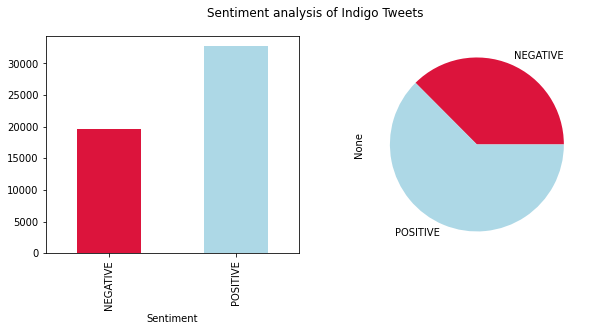

In [34]:
# Visualizing the overall sentiment distribution
import matplotlib.pyplot as plt
fig, subPlot =plt.subplots(nrows=1, ncols=2, figsize=(10,4))
fig.suptitle("Sentiment analysis of Indigo Tweets")
 
# Grouping the data
GroupedData=tweets_df.groupby('Sentiment').size()
 
# Creating the charts
GroupedData.plot(kind='bar', ax=subPlot[0], color=['crimson', 'lightblue'])
GroupedData.plot(kind='pie', ax=subPlot[1], colors=['crimson', 'lightblue']);

Most tweets are positive

### How positive are the tweets by representative?

In [41]:
tweets_df.groupby(['Representative', 'Sentiment']).count()[['text']].T

Representative Brendan Boyle          Brian Fitzpatrick           \
Sentiment           NEGATIVE POSITIVE          NEGATIVE POSITIVE   
text                    1322     1876               632     2567   

Representative Chrissy Houlahan          Conor Lamb          Dan Mueser  \
Sentiment              NEGATIVE POSITIVE   NEGATIVE POSITIVE   NEGATIVE   
text                        802     2397        167      599        792   

Representative          Dwight Evans          Fred Keller           \
Sentiment      POSITIVE     NEGATIVE POSITIVE    NEGATIVE POSITIVE   
text               1137         1435     1764        1340     1856   

Representative Glenn Thompson          Guy Reschenthaler          John Joyce  \
Sentiment            NEGATIVE POSITIVE          NEGATIVE POSITIVE   NEGATIVE   
text                      749     2445              1885     1306        573   

Representative          Lloyd Smucker          Madeleine Dean           \
Sentiment      POSITIVE      NEGATIVE POSITIVE       NEGATIVE POSITIVE   
text               1127          1271     1918           1229     1965   

Representative Mary Gay Scanlon          Matt Cartwright           \
Sentiment              NEGATIVE POSITIVE        NEGATIVE POSITIVE   
text                       1063     2136            1269     1923   

Representative Michael Doyle          Mike Kelly          Scott Perry  \
Sentiment           NEGATIVE POSITIVE   NEGATIVE POSITIVE    NEGATIVE   
text                    1503     1697       1225     1947        1282   

Representative          Susan Wild           
Sentiment      POSITIVE   NEGATIVE POSITIVE  
text               1913       1061     2139

The majority of representatives use Twitter to express mostly positive messages. For most representatives, the majority of their messages were positive with the exception of Guy Reschenthaler. 

### Is there a difference in positivity between Democrats and Republicans?

In [42]:
tweets_df.groupby(['party', 'Sentiment']).count()[['text']]

text
party      Sentiment       
Democratic NEGATIVE    9851
           POSITIVE   16496
Republican NEGATIVE    9749
           POSITIVE   16216

In the aggregate, tweets from Democratic representatives have the same rate of positivity as Republican representatives